This post is a follow up to my talk, _Practical Image Classification & Object Detection_ at PyData Delhi 2018. You can watch the talk here,


<iframe width="560" height="315" src="https://www.youtube.com/embed/mCQYXHJKZW8?start=5351" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>

<br>
and see the slides here:


<script async class="speakerdeck-embed" data-id="43741543531849cd83452ef9a55aa9fe" data-ratio="1.77777777777778" src="//speakerdeck.com/assets/embed.js"></script>

<br>
I spoke at length about the different kinds of problems in computer vision and how they are interpreted in deep learning architectures. I spent a fair bit of time on instance and semantic segmentation (for an introduction to these problems, watch [Justin Johnson](https://cs.stanford.edu/people/jcjohns/)'s lecture from the Stanford CS231 course [here](https://www.youtube.com/watch?v=nDPWywWRIRo)). In short, semantic segmentation deals with designating each pixel of an image as belonging to a class, and instance segmentation deals with identifying which instance of a class each pixel belongs to. The following images show an example of semantic versus instance segmentation.

<img src="/images/segmentation.png"></img>
<br>
At the outset, a semantic segmentation output can be converted to an instance segmentation output by detecting boundaries and labeling each enclosing object individually. Semantic segmentation is essentially a classification problem that is applied at each pixel of and image, and can be evaluated with any suitable classification metric. A useful metric to evaluate how capable a model is of learning the boundaries that are required for instance segmentation is called mAP of IoU - mean average precision of the intersection over union. This metric is designed specifically to evaluate instance segmentation performance. Here's a brief explanation of how it works.

Imagine that we're solving a binary semantic segmentation problem, where the task is to simply predict if a pixel belongs to the background or foreground. We first create, as the ground truth, an image with two circular objects in it. Note that the circles, at the point where they are closest to each other, are separated by very few pixels.

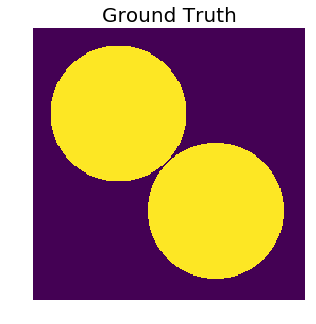

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import draw
%matplotlib inline

x = np.zeros((256, 256))
cy, cx = 80, 80
radius = 64
cy2 = cx2 = (np.sqrt(cy **2 + cx **2) + 2 * radius) * np.cos(np.pi / 4) + 1
o1r, o1c = draw.circle(cy, cx, radius)
o2r, o2c = draw.circle(cy2, cx2, radius)
x[o1r, o1c] = 1
x[o2r, o2c] = 1
plt.figure(figsize=(5, 5))
plt.imshow(x)
plt.axis('off')
_ = plt.title('Ground Truth', fontsize=20)

Now imagine that we have a model that is good at semantic segmentation, but not so much at instance segmentation. So it (somewhat) wrongly predicts a labeled output that is _almost_ identical to the ground truth, except it fills the gap that separates the two circles. After all, the circles are _almost_ touching anyway.

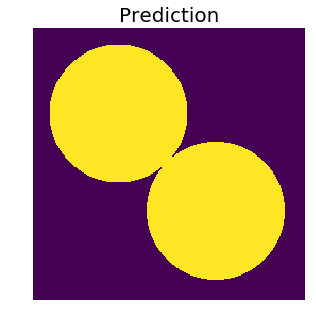

In [2]:
from skimage.morphology import binary_dilation

prediction = binary_dilation(x)
plt.figure(figsize=(5, 5))
plt.imshow(prediction)
plt.axis('off')
_ = plt.title('Prediction', fontsize=20)

Since this a binary classification problem, and we can tell that there is clear class imbalance, let's use the [F1 score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) to evaluate our prediction.

In [3]:
from sklearn.metrics import f1_score

print(f1_score(x.ravel(), prediction.ravel()))

0.9860563110515227


That's not bad at all. There are a very small number of pixels where the model is mistaken - the ones in the area where the circles are not supposed to be touching. Let's take a look at how well the other metric - mAP of IoU - does with this prediction. Here are a couple of functions that implement the mAP of IoU computation. Followed by a detailed explanation of the metric.

In [4]:
def iou(masks_true, masks_pred):
    """
    Get the IOU between each predicted mask and each true mask.

    Parameters
    ----------

    masks_true : array-like
        A 3D array of shape (n_true_masks, image_height, image_width)
    masks_pred : array-like
        A 3D array of shape (n_predicted_masks, image_height, image_width)

    Returns
    -------
    array-like
        A 2D array of shape (n_true_masks, n_predicted_masks), where
        the element at position (i, j) denotes the IoU between the `i`th true
        mask and the `j`th predicted mask.

    """
    if masks_true.shape[1:] != masks_pred.shape[1:]:
        raise ValueError('Predicted masks have wrong shape!')
    n_true_masks, height, width = masks_true.shape
    n_pred_masks = masks_pred.shape[0]
    m_true = masks_true.copy().reshape(n_true_masks, height * width).T
    m_pred = masks_pred.copy().reshape(n_pred_masks, height * width)
    numerator = np.dot(m_pred, m_true)
    denominator = m_pred.sum(1).reshape(-1, 1) + m_true.sum(0).reshape(1, -1)
    return numerator / (denominator - numerator)

def evaluate_image(masks_true, masks_pred, thresholds):
    """
    Get the average precision for the true and predicted masks of a single image,
    averaged over a set of thresholds

    Parameters
    ----------
    masks_true : array-like
        A 3D array of shape (n_true_masks, image_height, image_width)
    masks_pred : array-like
        A 3D array of shape (n_predicted_masks, image_height, image_width)

    Returns
    -------
    float
        The mean average precision of intersection over union between
        all pairs of true and predicted region masks.

    """
    int_o_un = iou(masks_true, masks_pred)
    benched = int_o_un > thresholds
    tp = benched.sum(-1).sum(-1)  # noqa
    fp = (benched.sum(2) == 0).sum(1)
    fn = (benched.sum(1) == 0).sum(1)
    return np.mean(tp / (tp + fp + fn))

Note that the IoU between any pair of binary masks can be any real number in $[0, 1]$. Therefore, it is necessary to apply a threshold the IoUs between all pairs of predicted and true masks, to get a meaningful evaluation. The convention used by many Kaggle competitions is to have a set of thresholds from 0.5 to 0.95 in steps of 0.05. In the following cell, we create this set of thresholds and use them to evaluate the metric.

In [5]:
# make the thresholds
THRESHOLDS = np.arange(0.5, 1, 0.05).reshape(10, 1, 1)

# segment the ground truth image into constituent masks
bg = np.zeros(x.shape)
true_mask_1 = bg.copy()
true_mask_1[o1r, o1c] = 1
true_mask_2 = bg.copy()
true_mask_2[o2r, o2c] = 1
y_true = np.array([true_mask_1, true_mask_2])

# reshape the prediction matrix to fit the format required by the `evaluate_image` function
y_pred = prediction.reshape((1,) + prediction.shape)

map_iou = evaluate_image(y_true, y_pred, THRESHOLDS)
print(map_iou)

0.0


<img src="/images/frustrated_jackie_chan.png"></img>

That was by design. On careful inspection, it is apparent that both of the _true_ masks account for less than half the area occupied by the _predicted_ mask. Thus, the _predicted_ mask has in IoU of less than 0.5 with each _true_ mask. Since we start thresholding the IoU values at 0.5, the prediction did not register a true positive with either of the true masks - ultimately leading to a score of zero.

Let's try another hacked prediction, where we create two circular objects again, but this time they share the same centers as their ground truth counterparts, and have a radius that is less than the true radius by six units. Then, let's evaluate both the metrics again on these new predictions.

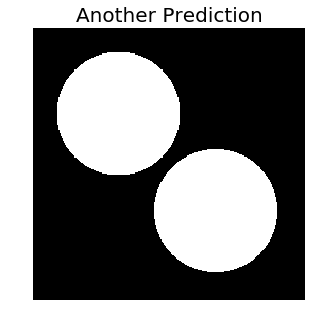

In [6]:
xnew = np.zeros((256, 256))
cy, cx = 80, 80
radius_new = 58
cy2 = cx2 = (np.sqrt(cy **2 + cx **2) + 2 * 64) * np.cos(np.pi / 4) + 1
o1r, o1c = draw.circle(cy, cx, radius_new)
o2r, o2c = draw.circle(cy2, cx2, radius_new)
xnew[o1r, o1c] = 1
xnew[o2r, o2c] = 1
plt.figure(figsize=(5, 5))
plt.imshow(xnew, cmap=plt.cm.gray)
plt.axis('off')
_ = plt.title('Another Prediction', fontsize=20)

In [7]:
# segment the predicted image into constituent masks
bg = np.zeros(xnew.shape)
predicted_mask_1 = bg.copy()
predicted_mask_1[o1r, o1c] = 1
predicted_mask_2 = bg.copy()
predicted_mask_2[o2r, o2c] = 1
y_pred = np.array([predicted_mask_1, predicted_mask_2])

fscore = f1_score(y_true.sum(0).ravel(), y_pred.sum(0).ravel())
print("F1 Score: {}".format(fscore))

map_iou = evaluate_image(y_true, y_pred, THRESHOLDS)
print("MAP of IoU: {}".format(map_iou))

F1 Score: 0.9014126584439418
MAP of IoU: 0.7


The pixelwise accuracy (the F1 score) has taken a hit, since the prediction has lost two circular rings surrounding the true masks, but is still not bad. However, the IoU has shot up disproportionately! This shows that the MAP of IoU penalizes incorrect region separation a lot more than it rewards pixelwise correctness.

As a more general example, suppose we have $K$ true masks, and $L$ predicted masks. Then, in order to calculate the MAP of IoU, we construct a matrix $I \in \mathbb R^{K \times L}$ as follows:
<br>

|$p_{1}$|$p_{2}$|$p_{3}$|$…$|$p_{l}$
:-----:|:-----:|:-----:|:-----:|:-----:|:-----:
$a_{1}$|$O_{11}$|$O_{12}$|$O_{13}$|$…$|$O_{1L}$
$a_{2}$|$O_{21}$|$O_{22}$|$O_{23}$|$…$|$O_{2L}$
$a_{3}$|$O_{31}$|$O_{32}$|$O_{33}$|$…$|$O_{3L}$
…|…|…|…|…|…
$a_K$|$O_{K1}$|$O_{K2}$|$O_{K3}$|$…$|$O_{Kl}$
<br>
where $O_{k, l}$ is the IoU of the $k$th true mask and the $l$th predicted mask. This matrix is whatt the `iou` function written above generates. Given our set of thresholds, $\Theta = \{0.5, 0.55, 0.6, ... 0.9, 0.95\}$, we can filter $I$ with all of them one by one. At each threshold $\theta_{i} \in \Theta$, we calculate a boolean matrix $I_{\theta_{i}} = I > \theta_{i}$. Using this matrix, we compute the following values:

* $t^{+}(\theta_{i})$: The number of true positives - the number of predicted masks that found a match with a true mask. This is equal to the number of rows in $I_{\theta_{i}}$ that have at least one positive value.
* $f^{+}(\theta_{i})$: The number of false positives - the number of predicted masks that found no match with a true mask. This is equal to the number of rows in $I_{\theta_{i}}$ that have no positive value.
* $f^{-}(\theta_{i})$: The number of false negatives - the number of true masks that found no predicted match. This is equal to the number of columns in $I_{\theta_{i}}$ that have no positive value.

<br>
With these values computed for all thresholds $\theta_{i} \in \Theta$, we finally calculate the MAP of IoU as follows:

<br>
$$ \cfrac{1}{|\Theta|}\sum_{\theta_{i} \in \Theta}\cfrac{t^{+}(\theta_{i})}{t^{+}(\theta_{i}) + f^{+}(\theta_{i}) + f^{-}(\theta_{i})}$$
<br>
This measure is what the `evaluate_image` function written above calculates.

A popular neural network architecture to perform semantic / instance segmentation is the UNet:
<img src="/images/unet.png"></img>
<br>
It puts together the best properties of a network that are useful for pixel segmentation:
1. It is fully convolutional
2. It doesn't suffer because of the size of the image
3. It incorporates learnable upsampling

<br>
A Keras implementation of a typical UNet is provided [here](https://github.com/jaidevd/jaidevd.github.io/blob/source/blog/posts/code/unet.py). This model can be compiled and trained as usual, with a suitable optimizer and loss. For semantic segmentation, the obvious choice is the categorical crossentropy loss. For instance segmentation, however, as we have demonstrated, pixelwise accuracy is not enough, and the model must learn the separation between nearby objects. Normally such separation can be done with [morphological operations](https://en.wikipedia.org/wiki/Mathematical_morphology) on the images, but these operations cannot easily be made a part of the learning of the model. So the alternative is to force the network to learn region separations in an entirely data-driven manner. The [UNet paper](https://arxiv.org/abs/1505.04597) provides an interesting way of doing this - introducing pre-computed weight maps into the loss function which penalizes the loss near the boundaries of regions more than elsewhere. These weight maps are calculated as follows:

<br>
$$ w(\mathbf{x}) = w_{c}(\mathbf{x}) + w_{0} \times exp \Biggl( -\frac{(d_{1}(\mathbf{x}) + d_{2}(\mathbf{x}))^2}{2\sigma^2} \Biggr)$$
<br>
Here, $w_{c}$, $d_{1}$ and $d_{2}$ are all functions over a two dimensional image such that:
* $w_{c}: \mathbb R^{m\times n} \rightarrow \mathbb R^{m\times n}$ is the class probability map.
* $d_{1}: \mathbb R^{m\times n} \rightarrow \mathbb R^{m\times n}$ is the distance to the border of the nearest cell,
* $d_{2}: \mathbb R^{m\times n} \rightarrow \mathbb R^{m\times n}$ is the distance to the border of the second nearest cell.

<br>
A vectorized implementation of $w$ is provided below in the `make_weight_map` function.

In [8]:
from skimage.segmentation import find_boundaries

w0 = 10
sigma = 5

def make_weight_map(masks):
    """
    Generate the weight maps as specified in the UNet paper
    for a set of binary masks.
    
    Parameters
    ----------
    masks: array-like
        A 3D array of shape (n_masks, image_height, image_width),
        where each slice of the matrix along the 0th axis represents one binary mask.

    Returns
    -------
    array-like
        A 2D array of shape (image_height, image_width)
    
    """
    nrows, ncols = masks.shape[1:]
    masks = (masks > 0).astype(int)
    distMap = np.zeros((nrows * ncols, masks.shape[0]))
    X1, Y1 = np.meshgrid(np.arange(nrows), np.arange(ncols))
    X1, Y1 = np.c_[X1.ravel(), Y1.ravel()].T
    for i, mask in enumerate(masks):
        # find the boundary of each mask,
        # compute the distance of each pixel from this boundary
        bounds = find_boundaries(mask, mode='inner')
        X2, Y2 = np.nonzero(bounds)
        xSum = (X2.reshape(-1, 1) - X1.reshape(1, -1)) ** 2
        ySum = (Y2.reshape(-1, 1) - Y1.reshape(1, -1)) ** 2
        distMap[:, i] = np.sqrt(xSum + ySum).min(axis=0)
    ix = np.arange(distMap.shape[0])
    if distMap.shape[1] == 1:
        d1 = distMap.ravel()
        border_loss_map = w0 * np.exp((-1 * (d1) ** 2) / (2 * (sigma ** 2)))
    else:
        if distMap.shape[1] == 2:
            d1_ix, d2_ix = np.argpartition(distMap, 1, axis=1)[:, :2].T
        else:
            d1_ix, d2_ix = np.argpartition(distMap, 2, axis=1)[:, :2].T
        d1 = distMap[ix, d1_ix]
        d2 = distMap[ix, d2_ix]
        border_loss_map = w0 * np.exp((-1 * (d1 + d2) ** 2) / (2 * (sigma ** 2)))
    xBLoss = np.zeros((nrows, ncols))
    xBLoss[X1, Y1] = border_loss_map
    # class weight map
    loss = np.zeros((nrows, ncols))
    w_1 = 1 - masks.sum() / loss.size
    w_0 = 1 - w_1
    loss[masks.sum(0) == 1] = w_1
    loss[masks.sum(0) == 0] = w_0
    ZZ = xBLoss + loss
    return ZZ

Here is an example of how the weight map affects a set of masks. We generate three circular regions such that two of them are much closer to each other than the third one. The weight map functions magnifies the values in the region that is close to boundaries more than other values.

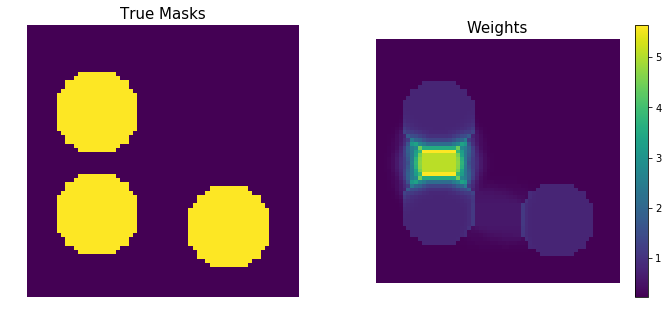

In [9]:
params = [(20, 16, 10), (44, 16, 10), (47, 47, 10)]
masks = np.zeros((3, 64, 64))
for i, (cx, cy, radius) in enumerate(params):
    rr, cc = draw.circle(cx, cy, radius)
    masks[i, rr, cc] = 1
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.imshow(masks.sum(0))
ax1.set_axis_off()
ax1.set_title('True Masks', fontsize=15)

weights = make_weight_map(masks)
pos = ax2.imshow(weights)
ax2.set_axis_off()
ax2.set_title('Weights', fontsize=15)
_ = fig.colorbar(pos, ax=ax2)

Application of these weight maps to the output of neural network and then finally computing the compunded loss is somewhat involved. A fully convolutional network like the UNet - since it has no dense layers at the end - needs 1 x 1 convolutions at the end to convert the convolutions from the previous layer to produce something on which categorical softmax can work. The output layer produces a volumne of size $h \times w \times K$, where $h$ and $w$ are the image height and width respectively and $K$ is the number of classes. Denoting the _unactivated_ output of the channel correspoding to the $k$th class as $a_{k}(\mathbf{x})$, the softmax activation is computed as
<br>

$$ p_{k}(\mathbf{x}) = \cfrac{exp(a_{k}(\mathbf{x}))}{\sum_{k'=1}^{K}exp(a_{k'}(\mathbf{x}))} $$
<br>

Then, a modified cross entropy loss is calculated as
<br>
$$E = \sum w(\mathbf{x})log(p_{l(\mathbf{x)}}(\mathbf{x}))$$
<br>

where $w(\mathbf{x})$ is the weight map function and $l(\mathbf{x})$ denotes the true label of each pixel, Thus, computing $E$ amounts to:

1. computing the softmax activation
2. using the true labels as a mask for this activation, (note how the function $l(\mathbf{x})$ is used),
3. summing the masked output along the dimension corresponding to the $K$ and taking it's log
4. multiply the log output with the weight map and aggregate the result across pixels

<br>
When using Keras with a Tensorflow backend, the crossentropy loss, by default, is a [manual computation of cross entropy](https://github.com/keras-team/keras/blob/2.2.2/keras/backend/tensorflow_backend.py#L3181), which doesn't allow for weighing the loss explicitly. The manual computation is necessary because the corresponding Tensorflow [loss](https://www.tensorflow.org/api_docs/python/tf/losses/softmax_cross_entropy) expects logits, whereas Keras losses expect probabilities.

Besides, it is clear that the loss we need isn't the usual categorical crossentropy. Notice that the weights have to be applied to the log of the activation _before_ the pixelwise sum is evaluated. My solution to this was to incorporate the weighing of the log of the activation into the Keras model itself, and leave only the aggregation to the loss function. Thus, the model ends up doing more than just generating the final set of softmax activations. It also takes the log of the activations and applies the weights to it. Therefore, the weight maps too become a part of the computational graph of the model - unlike in the case of conventional class weights, where it can be supplied at the time of loss calculation. So now the model takes three inputs - the images, their labels and their weight maps.

Thanks to Keras' beautiful functional API, all of this amounts to adding a few non-trainable layers to the model and writing a custom loss function to mimic only the aggregation of the categorical crossentropy function.

The entire script for the model is available [here](https://github.com/jaidevd/jaidevd.github.io/blob/source/blog/posts/code/weighted_loss_unet.py), but the essence of it is as follows:

```python
from keras.layers import Input, Conv2D, Lambda, multiply # etc
# Start making the UNET model as usual

image_input = Input(shape=(image_height, image_width, n_channels))
conv1 = Conv2D(64, 3)(image_input)

# add other layers

# Final 1 x 1 trainable conv layer that does the softmax.
softmax_op = Conv2D(n_classes, 1, activation='softmax')(previous_layer)

# Add a few non trainable layers to mimic the computation of the crossentropy
# loss, so that the actual loss function just has to peform the
# aggregation.
normalize_activation = Lambda(lambda x: x / tf.reduce_sum(x, len(x.get_shape()) - 1, True))(softmax_op)
clip_activation = Lambda(lambda x: tf.clip_by_value(x, _epsilon, 1. - _epsilon))(normalize_activation)
log_activation = Lambda(lambda x: K.log(x))(clip_activation)

# Add a new input to serve as the source for the weight maps
weight_map_ip = Input(shape=(image_height, image_width))
weighted_softmax = multiply([log_activation, weight_map_ip])

model = Model(inputs=[image_input, weight_map_ip], outputs=[weighted_softmax])
```

This model can now be compiled and trained as usual. Note that the three `Lambda` layers are identical to the operations in the [`keras.backend.tensorflow_backend.catgorical_crossentropy`](https://github.com/keras-team/keras/blob/2.2.2/keras/backend/tensorflow_backend.py#L3181). So essentially we have swallowed most of the functionality of the cross entropy loss into the model itself. I should re-emphasize that this had to be done because the weighted loss we wanted could not have been possible with the default loss function, since the scaling of the log of the activations (with the precomputed weights) has to be done _before_ the loss is aggregated.

I discovered the UNet paper a few months ago during the [Data Science Bowl 2018](https://www.kaggle.com/c/data-science-bowl-2018) competition on Kaggle. I spent a better part of three weeks on implementing the weight maps and incorporating them into my UNet. And it paid off fairly well - I jumped 504 places on the public leaderboard. In hindsight, data augmentation would have had the same (or perhaps a better) effect, but that fact that I was able to all of this shows how beautifully Keras' (and indeed, Tensorflow's) functional API has been designed.

### References
<ol>
<li>
Olaf Ronneberger, Philipp Fischer: “U-Net: Convolutional Networks for Biomedical Image Segmentation”, 2015; <a href='http://arxiv.org/abs/1505.04597'>arXiv:1505.04597</a>.
</li>
</ol>